### MIS Implementation ###

We start by taking images from the dataset and populating a 2-D graph with their embeddings. Images that are similar will be close on this graph. We will then run an MIS algorithm on the graph to determine which images we will use for the training.

In [336]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the MobileNetV2 model from TensorFlow Hub
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
model = hub.KerasLayer(model_url, output_shape=[1280], input_shape=(224, 224, 3), trainable=False)


In [337]:
paths = []
def load_and_preprocess_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def load_and_preprocess_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    return img

def get_image_embeddings(image_paths):
    embeddings = []
    for i, path in enumerate(image_paths):
        img = load_and_preprocess_image(path)
        img = np.expand_dims(img, axis=0)
        embedding = model(img)
        embeddings.append(embedding[0].numpy())  
        paths.append(path[:-4])
    return np.array(embeddings)

image_dir = 'HAM10000_images_part_1'
N = 10
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)[:N**2] if fname.endswith('.jpg')]

embeddings = get_image_embeddings(image_paths)


In [338]:
import numpy as np

def pca(X, num_components):
    # Statistical Calculations
    X_meaned = X - np.mean(X, axis=0)
    cov_mat = np.cov(X_meaned, rowvar=False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
    
    # Sort the eigenvalues in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalues = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
    
    X_reduced = np.dot(eigenvector_subset.transpose(), X_meaned.transpose()).transpose()
    
    return X_reduced

num_components = 2  # Number of components to keep
embeddings_reduced = pca(embeddings, num_components)
preprocessed_images = {}
for path, embed in zip(paths, embeddings_reduced):
    preprocessed_images[path] = embed

print("Reduced Embeddings Shape:", embeddings_reduced.shape)


Reduced Embeddings Shape: (99, 2)


In [167]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph
G = nx.Graph()

for key in preprocessed_images:
    G.add_node(key, position = preprocessed_images[key])

k = 1

def euclidean_distance(point1, point2):
    ans = np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
    return ans 

# Add edges based on distance (k < 1 means all points less than 1 apart share an edge)
for key in preprocessed_images:
    for other_key in preprocessed_images:
        node1 = key
        node2 = other_key
        pos1 = preprocessed_images[node1]
        pos2 = preprocessed_images[node2]
        if node1 != node2:
            distance = euclidean_distance(pos1, pos2)
            if distance <= k:
                G.add_edge(node1, node2)

In [ ]:
l = nx.maximal_independent_set(G)
print(l)

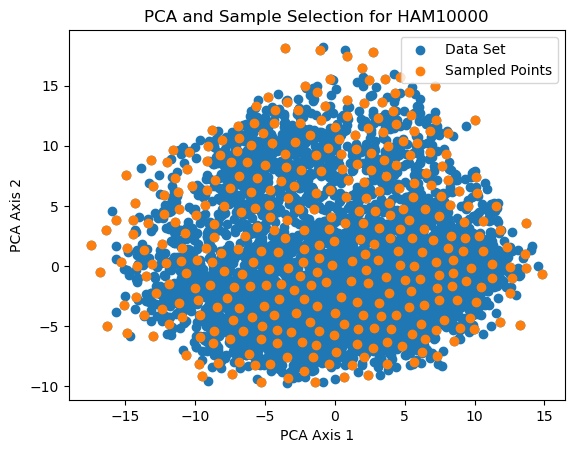

In [192]:
# Create a new graph
X = []
Y = []
X_new = []
Y_new = []
for key in preprocessed_images:
    pos = preprocessed_images[key]
    X.append(pos[0])
    Y.append(pos[1])
    if key in l:
        X_new.append(pos[0])
        Y_new.append(pos[1])


plt.scatter(X, Y, label="Data Set")
plt.scatter(X_new, Y_new, label="Sampled Points")
plt.xlabel("PCA Axis 1")
plt.ylabel("PCA Axis 2")
plt.title("PCA and Sample Selection for HAM10000")
#plt.title("PCA for HAM10000")
plt.legend()
plt.show()

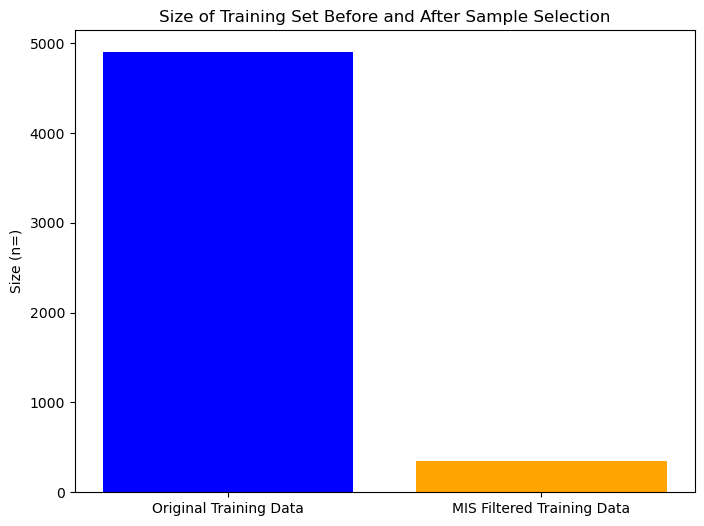

In [193]:

# Values to plot
values = [len(paths), len(l)]
labels = ['Original Training Data', 'MIS Filtered Training Data']

# Plotting the histogram (bar chart)
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['blue', 'orange'])
plt.ylabel('Size (n=)')
plt.title('Size of Training Set Before and After Sample Selection')
plt.show()

### Dataset Management ###

Now that we have the selected images, we will ready the data to be used by the neural network.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd

df = pd.read_csv('HAM10000_metadata.csv')
df = df.drop("lesion_id", axis=1)

def data_preprocess(df):    
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True, keep='first')
    le = LabelEncoder()
    #ohe = OneHotEncoder().fit(df['Attrition_Flag'])
    for col in cat_cols:
        if col != 'image_id':
            df[col] = le.fit_transform(df[col])
            print(f"converted {df[col]}")
    scaler = StandardScaler()
    for col in num_cols:
        df[[col]] = scaler.fit_transform(df[[col]])
    return df


df = data_preprocess(df)

In [ ]:
paths = [path.split('/')[1] for path in paths if '/' in path] + [path for path in paths if not '/' in path] 
filtered_df = df[df['image_id'].isin(paths)]
l = [ele.split("/")[1] for ele in l]
small_filtered_df = df[df['image_id'].isin(l)] # l is the MIS solution

X = filtered_df.drop('dx', axis=1)
y = filtered_df['dx']
small_X = small_filtered_df.drop('dx', axis=1)
small_y = small_filtered_df['dx']
print(small_y)


# Split the data into training and testing sets
X = np.array(X.drop('image_id', axis=1), dtype = 'float32')
y = np.array(y, dtype = 'float32')
y = np.reshape(y, (len(y), 1))

small_X = np.array(small_X.drop('image_id', axis=1), dtype = 'float32')
small_y = np.array(small_y, dtype = 'float32')
small_y = np.reshape(small_y, (len(small_y), 1))

Note the following cell shows us how large the dataset is versus how many training examples we select

In [201]:
print(len(filtered_df))
print(len(small_filtered_df))

4896
349


### Neural Network ###

Now, the data is ready and we can run the neural network. The code below implements the fully connected NN and provides us graphs to gauge the effectiveness of sample selection.

In [315]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split

def get_model(X_train, X_test, y_train, y_test, name=None):
    model = Sequential([
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(y_train.shape[0], activation='softmax')  # Output layer for multiclass classification
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
                metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=40, batch_size=300, validation_split=0.1, verbose=False)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test loss: {loss:.4f}, test accuracy: {accuracy:.4f}, name of model: {name}')
    return history, loss, accuracy

In [316]:
import random

r = 100

indices = random.sample(range(len(X)), len(small_X))
X_random = np.array([X[index] for index in indices])
y_random = np.array([y[index] for index in indices])

X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(small_X, small_y, test_size=0.2, random_state=r)
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X_random, y_random, test_size=0.2, random_state=r)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=r)


history_full, loss_full, accuracy_full = get_model(X_train_full, X_test_full, y_train_full, y_test_full, name="Full")
history_random, loss_random, accuracy_random = get_model(X_train_random, X_test_random, y_train_random, y_test_random, name="Random")
history_selected, loss_selected, accuracy_selected = get_model(X_train_selected, X_test_selected, y_train_selected, y_test_selected, name="Selected")

31/31 [==============================] - 0s 2ms/step - loss: 0.8427 - accuracy: 0.6806
Test loss: 0.8427, test accuracy: 0.6806, name of model: Full
3/3 [==============================] - 0s 2ms/step - loss: 3.4581 - accuracy: 0.0857
Test loss: 3.4581, test accuracy: 0.0857, name of model: Random
3/3 [==============================] - 0s 1ms/step - loss: 1.8149 - accuracy: 0.6714
Test loss: 1.8149, test accuracy: 0.6714, name of model: Selected


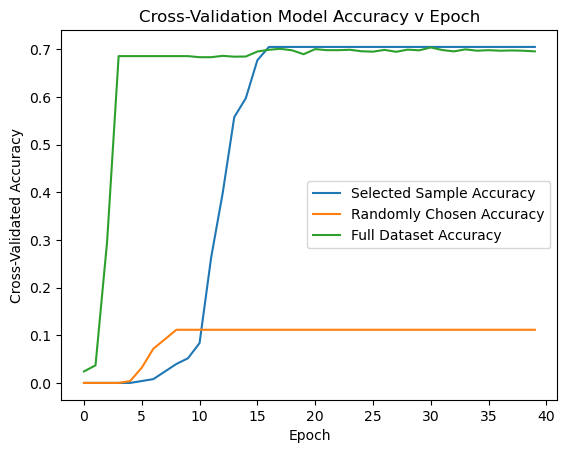

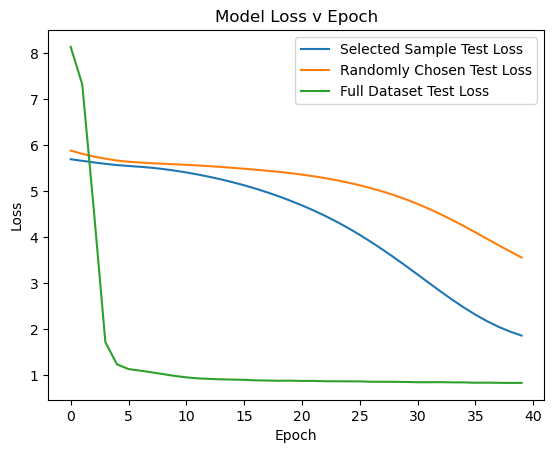

In [318]:
import matplotlib.pyplot as plt

plt.plot(history_selected.history['accuracy'], label='Selected Sample Accuracy')
plt.plot(history_random.history['accuracy'], label='Randomly Chosen Accuracy')
plt.plot(history_full.history['accuracy'], label='Full Dataset Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Cross-Validation Model Accuracy v Epoch')
plt.legend()
plt.show()

plt.plot(history_selected.history['loss'], label='Selected Sample Test Loss')
plt.plot(history_random.history['loss'], label='Randomly Chosen Test Loss')
plt.plot(history_full.history['loss'], label='Full Dataset Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss v Epoch')
plt.legend()
plt.show()

In [341]:
import numpy as np
import math
import random

def calculate_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def snap_to_lattice_grid(points):
    lattice_sites = [(i * 4.5, j * 4.5) for i in range(0, 9) for j in range(0, 9)]
    modified_points = [(name, (coords[0] * 4.5, coords[1] * 4.5)) for name, coords in points.items()]
    random.shuffle(modified_points)
    selected = modified_points[:50]

    columns = {i: [] for i in range(0, 9)}  # Using a dictionary to hold columns for easier mapping

    for name, point in selected:
        closest_site = None
        min_distance = float('inf')

        for site in lattice_sites:
            distance = calculate_distance(site, point)
            if distance < min_distance:
                min_distance = distance
                closest_site = site

        # Map the name and point to the closest site, ensuring the output includes the image name
        if closest_site:
            column_index = int(closest_site[0] / 4.5)  # Determine the column based on x-coordinate
            columns[column_index].append((name, closest_site))

    # Convert dictionary back to list if needed or leave as is for easier interpretation
    return columns

# Example usage
columns = snap_to_lattice_grid(preprocessed_images)

# Example to print or analyze output
for col, items in columns.items():
    print(f"Column {col}: {items}")


Column 0: [('HAM10000_images_part_1/ISIC_0028385', (0.0, 36.0)), ('HAM10000_images_part_1/ISIC_0026357', (0.0, 0.0)), ('HAM10000_images_part_1/ISIC_0027897', (0.0, 0.0)), ('HAM10000_images_part_1/ISIC_0025879', (0.0, 9.0)), ('HAM10000_images_part_1/ISIC_0024346', (0.0, 22.5)), ('HAM10000_images_part_1/ISIC_0027459', (0.0, 13.5)), ('HAM10000_images_part_1/ISIC_0025058', (0.0, 0.0)), ('HAM10000_images_part_1/ISIC_0026790', (0.0, 0.0)), ('HAM10000_images_part_1/ISIC_0026380', (0.0, 9.0)), ('HAM10000_images_part_1/ISIC_0024391', (0.0, 36.0)), ('HAM10000_images_part_1/ISIC_0028959', (0.0, 0.0)), ('HAM10000_images_part_1/ISIC_0029064', (0.0, 22.5)), ('HAM10000_images_part_1/ISIC_0025272', (0.0, 13.5)), ('HAM10000_images_part_1/ISIC_0025528', (0.0, 18.0)), ('HAM10000_images_part_1/ISIC_0025845', (0.0, 0.0)), ('HAM10000_images_part_1/ISIC_0027115', (0.0, 0.0)), ('HAM10000_images_part_1/ISIC_0028554', (0.0, 18.0)), ('HAM10000_images_part_1/ISIC_0026021', (0.0, 18.0)), ('HAM10000_images_part_1/I